<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/11_causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal inference - linear regression

Exposing confounds and common causes with OLS.

Does $X$ causally affect $Y$ assuming that Z may be a common cause for $X$ and $Y$, i.e. prior knowledge model assumes: $X \leftarrow Z \rightarrow Y$, $X \rightarrow Y$

## Adjustment formula

do($X$) while controlling for $Z$:

$$P(Y|do(x)) = \sum_z P(Y|x,z)P(z)$$

## Linear models

Structural equations:

$$Z \leftarrow U_z$$
$$X \leftarrow \beta_{xz} Z + U_x$$
$$Y \leftarrow \beta_{yx} X + \beta_{yz} Z + U_x$$

Parameters $\beta$ reflect causal effect to estimate, $U_z$ and $U_y$ are unobservable sources of variance ("omitted factors").

Role of $X$ on $Y$ is _confounded_ by common cause, $Z$. Can _control_ for $Z$ by estimating OLS $\beta$ coefficients: $y = \beta_{yx}x + \beta_{yz}z + e_y$

Denoted $r_{yx.z}$, $r_{yz.x}$ to make explicit their dependence on other variables.

With OLS, we can estimate a few other associations, e.g.:

$$ y = r_{yx}x + e_y , \space\space z = r_{zx}x + e_z $$

Well-established property of OLS reveals bias introduced by $Z$:

$$ r_{yx} = \beta_{yx} + \beta{yz} r_{zx} $$$

Association ($X \rightarrow Y$) = direct effect ($X \rightarrow Y$) + bias ($X \leftarrow Z \rightarrow Y$)

In [1]:
!pip install git+https://github.com/jd2504/bmedsp/

  Cloning https://github.com/jd2504/bmedsp/ to /tmp/pip-req-build-4wxo89v9
  Running command git clone --filter=blob:none --quiet https://github.com/jd2504/bmedsp/ /tmp/pip-req-build-4wxo89v9
  Resolved https://github.com/jd2504/bmedsp/ to commit ce357a1e30a109abe7b2fd79c1ffde142735e088
  Preparing metadata (setup.py) ... done
  Created wheel for bmedsp: filename=bmedsp-0.0.1-py3-none-any.whl size=3430 sha256=07cf8848465063eb895594ff0e8abdfbb306bb7064d01429e7ab9077810e9223
  Stored in directory: /tmp/pip-ephem-wheel-cache-tb_vvpt7/wheels/65/09/3a/abdc76fe54b7d29abb936f7855ed3b1722ce2b155a0d58bce4
Successfully built bmedsp


In [2]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
# from scipy import stats
from matplotlib import pyplot as plt

from bmedsp import parrakit as pk

In [3]:
x = pk.grab_mat('cause_or_confound.mat')

https://parralab.org/teaching/biomed-dsp/cause_or_confound.mat
dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y', 'Z'])
b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Apr 28 11:57:53 2022'


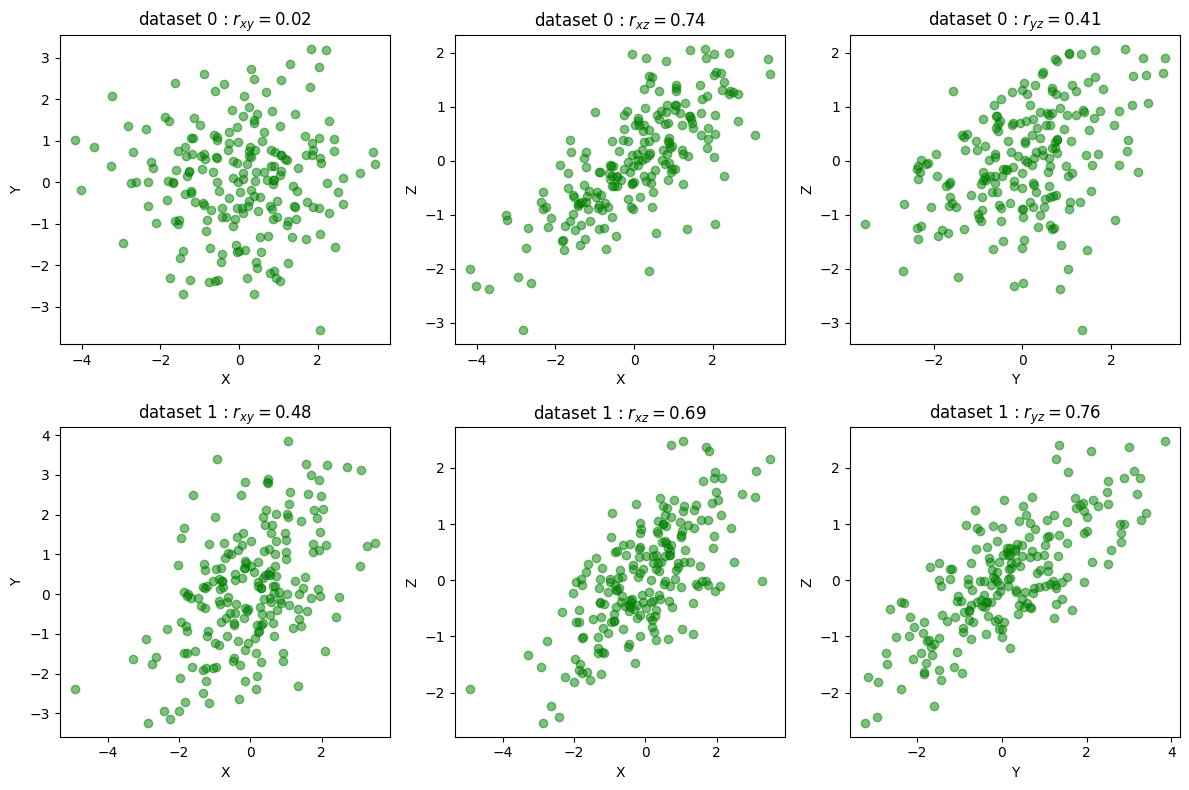

In [4]:
from itertools import combinations

plt.figure(figsize=(12,8))

def plt_corr(data, vars, set_n, plot_n):
    plt.subplot(2,3,plot_n)
    v1, v2 = data[vars[0]][:,set_n], data[vars[1]][:,set_n]

    r = np.corrcoef(v1,v2)[0,1]
    plt.plot(v1,v2,'o',alpha=0.5, c='g')
    subplot_title = "r_{" + str(vars[0]+vars[1]).lower()+"}=" + str(float(round(r,2)))
    plt.title(f"dataset {set_n} : "+f"${subplot_title}$")
    plt.xlabel(vars[0])
    plt.ylabel(vars[1])


plt_i = 1
for var in combinations(['X','Y','Z'],2):
    plt_corr(x, var,0, plt_i)
    plt_corr(x, var,1, plt_i+3)
    plt_i+=1

plt.tight_layout()
plt.show()

In [5]:
def estimate_betas(regressors, dep_var):
    params_output = {}
    m = sm.OLS(dep_var, regressors)
    results = m.fit()
    params_output = list([results.params[1:].tolist(), results.pvalues[1:].tolist()])
    return results, params_output

models = {}
m_params = {'info': """Dataset > model > {element_1: b coeffs, element_2: b p-value}"""}

for i in range(2):
    X, Y, Z = x['X'][:,i], x['Y'][:,i], x['Z'][:,i]
    models[i] = {}
    m_params[i] = {}

    model = 'zx' # test potential confound on independent var
    models[i][model], m_params[i][model] = estimate_betas(sm.add_constant(Z), X)

    model = 'zy' # test confound on dependent var
    models[i][model], m_params[i][model] = estimate_betas(sm.add_constant(Z), Y)

    model = 'xy'
    models[i][model], m_params[i][model] = estimate_betas(sm.add_constant(X), Y)

    model = 'zxy' # control for confound
    models[i][model], m_params[i][model] = estimate_betas(sm.add_constant(np.column_stack((Z,X))), Y)

In [6]:
def model_summary(set_n, model, full=True, models_dict=models):
    b_list = ['bias']+list(model)[:-1]
    if full:
        print(models_dict[set_n][model].summary(xname=b_list))
    else:
        print(models_dict[set_n][model].summary(xname=b_list).tables[1])

# Results

In [7]:
m_params

{'info': 'Dataset > model > {element_1: b coeffs, element_2: b p-value}',
 0: {'zx': [[1.0673204880002136], [9.200226767136312e-36]],
  'zy': [[0.5192777252118206], [1.9411223757084694e-09]],
  'xy': [[0.017232015063070472], [0.7831657417107701]],
  'zxy': [[1.102439724958743, -0.5463794673702593],
   [1.267278550913733e-19, 9.824700473026987e-12]]},
 1: {'zx': [[0.9536504468447411], [2.8272003893881654e-29]],
  'zy': [[1.1512965971111468], [1.2840718736364404e-38]],
  'xy': [[0.5216824494497312], [9.49405542529757e-13]],
  'zxy': [[1.2383346183672255, -0.09126826453450804],
   [1.0194589005575543e-27, 0.19163092690348865]]}}

In [8]:
model_summary(0,'xy',full=False)
model_summary(0,'zxy',full=False)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bias           0.0641      0.091      0.706      0.481      -0.115       0.243
x              0.0172      0.063      0.276      0.783      -0.106       0.141
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bias           0.0738      0.074      1.000      0.318      -0.072       0.219
z              1.1024      0.109     10.110      0.000       0.887       1.317
x             -0.5464      0.075     -7.240      0.000      -0.695      -0.398


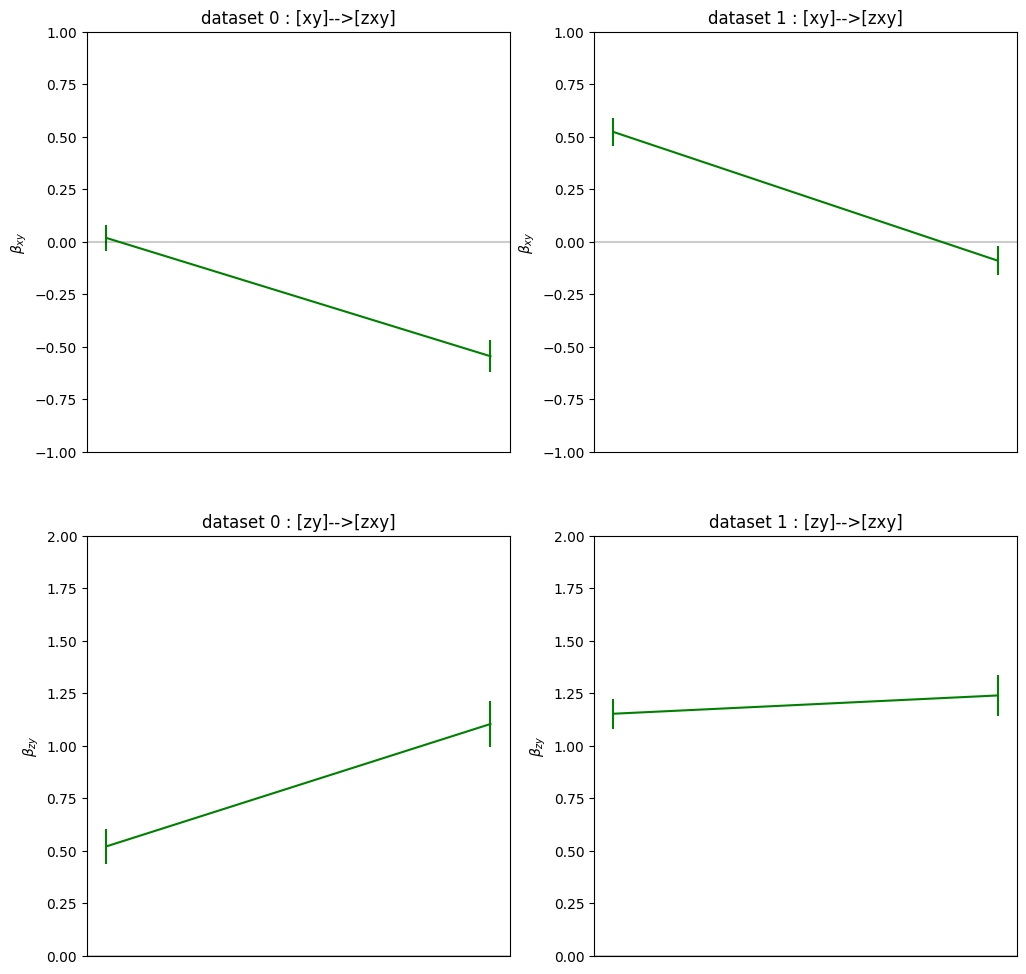

In [28]:
plt.figure(figsize=(12, 12))

for i in range(2):
    plt.subplot(2,2,i+1)
    plt.errorbar([0,1], [models[i]['xy'].params[1], models[i]['zxy'].params[2]],
                 yerr=[models[i]['xy'].bse[1], models[i]['zxy'].bse[2]], c='g')
    plt.axhline(y=0, c='k', alpha=0.2)
    plt.ylabel(r"$\beta_{xy}$")
    plt.ylim([-1, 1])
    plt.xticks([])
    plt.title(f"dataset {i} : [xy]-->[zxy]")

for i in range(2):
    plt.subplot(2,2,i+3)
    plt.errorbar([0,1], [models[i]['zy'].params[1], models[i]['zxy'].params[1]],
                 yerr=[models[i]['zy'].bse[1], models[i]['zxy'].bse[1]], c='g')
    plt.axhline(y=0, c='k', alpha=0.2)
    plt.ylabel(r"$\beta_{zy}$")
    plt.ylim([0, 2.])
    plt.xticks([])
    plt.title(f"dataset {i} : [zy]-->[zxy]")
plt.show()

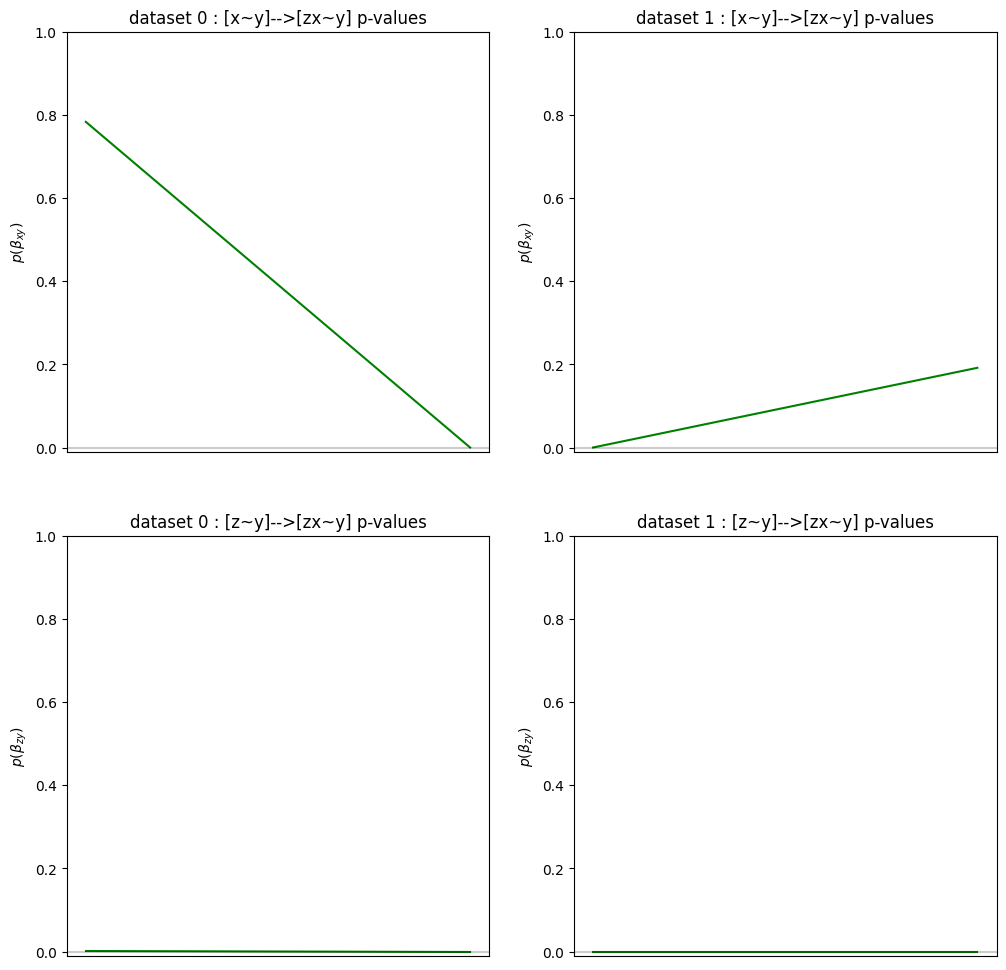

In [29]:
plt.figure(figsize=(12, 12))

for i in range(2):
    plt.subplot(2,2,i+1)
    plt.plot([0,1], [models[i]['xy'].pvalues[1], models[i]['zxy'].pvalues[2]], c='g')
    plt.axhline(y=0, c='k', alpha=0.2)
    plt.ylabel(r"$p(\beta_{xy})$")
    plt.ylim([-0.01,1])
    plt.xticks([])
    plt.title(f"dataset {i} : [x~y]-->[zx~y] p-values")

for i in range(2):
    plt.subplot(2,2,i+3)
    plt.plot([0,1], [models[i]['zy'].pvalues[1], models[i]['zxy'].pvalues[1]], c='g')
    plt.axhline(y=0, c='k', alpha=0.2)
    plt.ylabel(r"$p(\beta_{zy})$")
    plt.ylim([-0.01,1])
    plt.xticks([])
    plt.title(f"dataset {i} : [z~y]-->[zx~y] p-values")
plt.show()

## Dataset 1

- $X$ & $Y$ assoc. (naive model) appears nonexistant: $\beta_{XY}=0.0172$ ($p=0.783$), $r_{XY} = 0.02$
- Significant negative assoc. after controlling for confound $Z$: $\beta_{XY}=-0.5464$ ($p=0.000$)
- $Z$ assoc. also significant: $\beta_{ZY}=1.1024$ ($p=0.000$)

$$Z \rightarrow Y (\beta_{ZY}=1.1024)$$
$$ Z \rightarrow X (r_{XZ}=0.74)$$

$$X \rightarrow Y (\beta_{XY}=-0.5463)$$

$X$ causally affects $Y$, but effect was hidden until confound was accounted for. Adjusted model is significant improvement on naive model ($F=102.22$, $p=0.000$)

In [20]:
m = models[0]
anova_lm(m['xy'], m['zxy'])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,198.0,325.780046,0.0,NaN,NaN,NaN
1,197.0,214.485327,1.0,111.294719,102.221723,1.267279e-19


## Dataset 2

- Positive, significant assoc. between $X$ and $Y$: $\beta_{XY}=0.5217$ ($p=0.000$)
- After adjusting for confound $Z$: $\beta_{ZY}=1.2383$ ($p=0.000$), $\beta_{XY}=-0.0913$ ($p=0.192$)
- $Z$ is common cause to $X$ and $Y$

$$Z \rightarrow Y (\beta_{ZY}=1.2383)$$
$$ Z \rightarrow X (r_{XZ}=0.69)$$

Apparent and spurious effect of $X$ on $Y$ in naive model, disappears when confound accounted for. Adjusted model is significant improvement on naive model ($F=106.04$, $p=0.000$)

In [ ]:
m = models[1]
anova_lm(m['xy'], m['zxy'])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,198.0,334.657155,0.0,NaN,NaN,NaN
1,197.0,182.603332,1.0,152.053823,164.041931,1.019459e-27


## try to estimate the .mat data's causal order...

In [ ]:
from numpy.random import randn

N = 200

U_z = np.random.randn(N,1) # confound
U_y = np.random.randn(N,1)
U_x = np.random.randn(N,1)

In [ ]:
# dataset 1  - Z -> X -> Y
beta_yx_1 = -0.55
beta_xz_1 = 0.74
beta_yz_1 = 1.10
Z1 = U_z
X1 = beta_xz_1 * Z1 + U_x
Y1 = beta_yx_1 * X1 + beta_yz_1 * Z1 + U_y


# dataset 2 - Z common cause
beta_xz_2 = 0.69
beta_yz_2 = 1.24
Z2 = U_z
X2 = beta_xz_2 * Z2 + U_x
Y2 = beta_yz_2 * Z2 + U_y


x_gen = {
    'X': np.column_stack([X1.flatten(), X2.flatten()]),
    'Y': np.column_stack([Y1.flatten(), Y2.flatten()]),
    'Z': np.column_stack([Z1.flatten(), Z2.flatten()]),
}

generated data


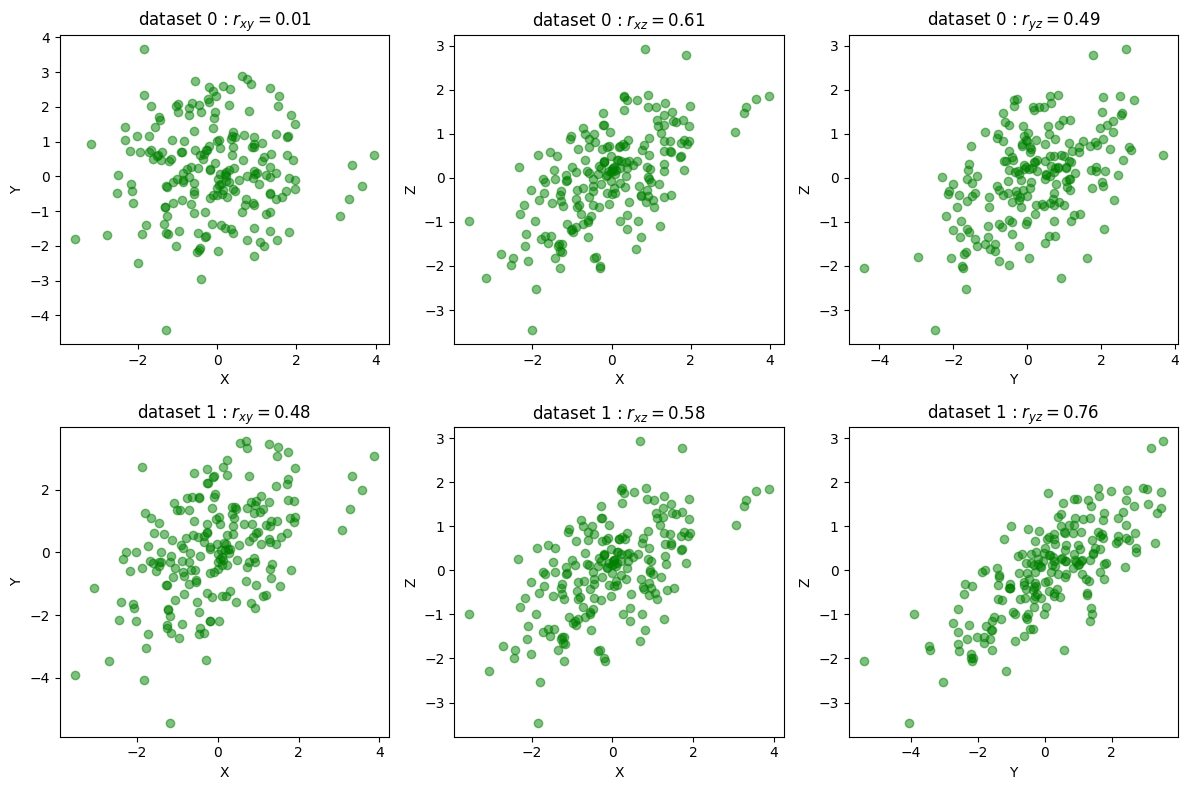

original data again to compare...


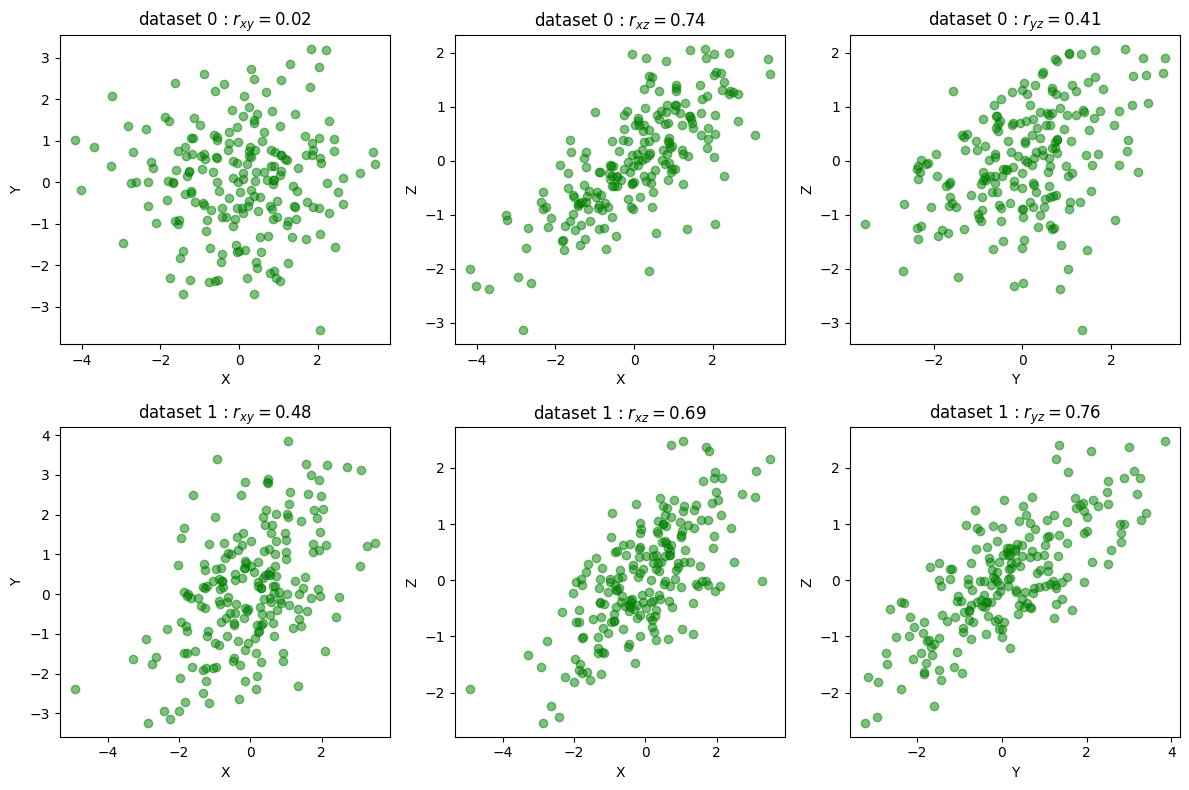

In [ ]:
# same plots with generated data

plt.figure(figsize=(12,8))

print("generated data")
plt_i = 1
for var in combinations(['X','Y','Z'],2):
    plt_corr(x_gen, var,0, plt_i)
    plt_corr(x_gen, var,1, plt_i+3)
    plt_i+=1
plt.tight_layout()
plt.show()

print("original data again to compare...")
plt.figure(figsize=(12,8))

plt_i = 1
for var in combinations(['X','Y','Z'],2):
    plt_corr(x, var,0, plt_i)
    plt_corr(x, var,1, plt_i+3)
    plt_i+=1
plt.tight_layout()
plt.show()